<a href="https://colab.research.google.com/github/amanjain487/tsai-eva6/blob/main/Assignments/S5/EVA6_Session5_CODE5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR,OneCycleLR

In [42]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-10.0, 10.0), fill=(0,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,), (0.1307,) normalizes the first layer ONLY
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [43]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [44]:
def get_num_correct(preds, labels):
  return preds.argmax(dim=1).eq(labels).sum().item()

In [45]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=64, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [46]:
dropout_value=0.01
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=20, kernel_size=3, padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(20),
            nn.Dropout2d(dropout_value)
        ) # output_size = 26*26*20

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=3, padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout2d(dropout_value)
        ) # output_size = 24*24*10

        self.maxPool = nn.MaxPool2d(2,2)#output=12*12*10

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=15, kernel_size=3, padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(15),
            nn.Dropout2d(dropout_value)
        )#output= 10*10*15

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=15, kernel_size=3, padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(15),
            nn.Dropout2d(dropout_value)
        )#output = 8*8*15

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=15, kernel_size=3, padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(15),
            nn.Dropout2d(dropout_value)
        )#output = 6*6*15


        self.GAP = nn.AvgPool2d(6)#output = 1*1*15

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=10, kernel_size=1, padding=0, bias=False)
        )#output = 1*1*10


    def forward(self, x):
        
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.maxPool(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.GAP(x)
        x = self.convblock6(x)
      
        x = x.reshape(-1,10)

        return F.log_softmax(x, dim=-1)

In [47]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 20, 26, 26]             180
              ReLU-2           [-1, 20, 26, 26]               0
       BatchNorm2d-3           [-1, 20, 26, 26]              40
         Dropout2d-4           [-1, 20, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]           1,800
              ReLU-6           [-1, 10, 24, 24]               0
       BatchNorm2d-7           [-1, 10, 24, 24]              20
         Dropout2d-8           [-1, 10, 24, 24]               0
         MaxPool2d-9           [-1, 10, 12, 12]               0
           Conv2d-10           [-1, 15, 10, 10]           1,350
             ReLU-11           [-1, 15, 10, 10]               0
      BatchNorm2d-12           [-1, 15, 10, 10]              30
        Dropout2d-13           [-1, 15, 10, 10]               0
           Conv2d-14             [

In [48]:
training_MNIST_loss, training_MNIST_accuracy, testing_MNIST_accuracy, testing_MNIST_loss=[], [], [], []


def train(network, device, train_loader, optimizer, epoch):
  network.train()
  processed = 0
  total_correct = 0
  loss = 0

  for batch in train_loader:
    images, labels = batch
    images = images.to(device)
    labels = labels.to(device)

    preds = network(images) # Pass Batch
    loss = F.nll_loss(preds, labels) # Calculate Loss
    training_MNIST_loss.append(loss.item())
    
    total_correct += get_num_correct(preds, labels)
    processed += len(labels)

    optimizer.zero_grad()
    loss.backward() # Calculate Gradients
    optimizer.step() # Update Weights
  
  training_MNIST_accuracy.append(100*total_correct/processed)

  print("Training: loss %.6f total_correct:%.2f " %(loss ,100*total_correct/processed ))

def test (network, device, test_loader):
  network.eval()
  total_correct = 0
  processed = 0
  loss = 0

  with torch.no_grad():
    for batch in test_loader:
      images, labels = batch
      images = images.to(device)
      labels = labels.to(device)
    
      preds = network(images)
      total_correct += get_num_correct(preds, labels)
      loss += F.nll_loss(preds, labels)
      processed += len(labels)

    loss = loss/len(test_loader.dataset)

    testing_MNIST_accuracy.append(100*total_correct/processed)
    testing_MNIST_loss.append(loss)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        loss, total_correct, len(test_loader.dataset),
        100. * total_correct / len(test_loader.dataset)))


In [49]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

for epoch in range(0, 14):
    print("EPOCH:", epoch, "LR = ", scheduler.get_lr())
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0 LR =  [0.01]


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Training: loss 0.090785 total_correct:90.68 
Test set: Average loss: 0.0009, Accuracy: 9822/10000 (98.22%)

EPOCH: 1 LR =  [0.01]
Training: loss 0.266926 total_correct:97.51 
Test set: Average loss: 0.0007, Accuracy: 9869/10000 (98.69%)

EPOCH: 2 LR =  [0.01]
Training: loss 0.019287 total_correct:97.97 
Test set: Average loss: 0.0005, Accuracy: 9903/10000 (99.03%)

EPOCH: 3 LR =  [0.01]
Training: loss 0.004577 total_correct:98.19 
Test set: Average loss: 0.0005, Accuracy: 9905/10000 (99.05%)

EPOCH: 4 LR =  [0.01]
Training: loss 0.140120 total_correct:98.44 
Test set: Average loss: 0.0004, Accuracy: 9920/10000 (99.20%)

EPOCH: 5 LR =  [0.01]
Training: loss 0.017699 total_correct:98.55 
Test set: Average loss: 0.0004, Accuracy: 9926/10000 (99.26%)

EPOCH: 6 LR =  [0.0001]
Training: loss 0.013344 total_correct:98.84 
Test set: Average loss: 0.0003, Accuracy: 9945/10000 (99.45%)

EPOCH: 7 LR =  [0.001]
Training: loss 0.009513 total_correct:98.91 
Test set: Average loss: 0.0003, Accuracy: 

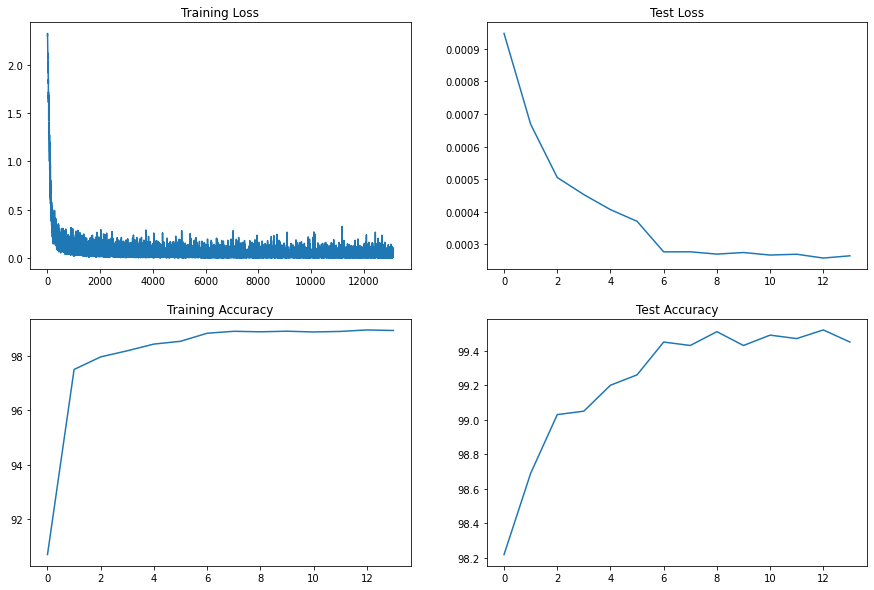

In [50]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(training_MNIST_loss)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(training_MNIST_accuracy)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(testing_MNIST_loss)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(testing_MNIST_accuracy)
axs[1, 1].set_title("Test Accuracy")
training_MNIST_loss, training_MNIST_accuracy, testing_MNIST_accuracy, testing_MNIST_loss=[], [], [], []
